In [3]:
#Objective: predicting the trip duration accurately

Extract data we've been given and divide into reasonable chunks

In [4]:
import pandas as pd


file_path = "training_dataset/training_dataset.csv"

chunk_size = 50_000  

chunks = []

data_frame = None

for chunk in pd.read_csv(file_path, chunksize=chunk_size):
    if data_frame is None:
        data_frame = chunk
    else:
        data_frame = pd.concat([data_frame, chunk])

KeyboardInterrupt: 

Process the data. Remove whatever that's uncessary and check for missing values. Either remove the missing or replace them. 

But first, check what we're missing and working with.

In [ ]:
missing_values = data_frame.isnull().sum()
print("Number of missing values are: ", missing_values) 

# Check for missing values
# missing_values = data_frame.isnull().sum()
# print("Number of missing values are: ", missing_values) 

print("-------------------------------------------------")

# Show summary statistics
print(data_frame.info())
print(data_frame.describe())

Number of missing values are:  ID                           0
vendorid                     0
tpep_pickup_datetime         0
tpep_dropoff_datetime        0
passenger_count          48490
trip_distance                0
ratecodeid               48490
store_and_fwd_flag       48490
pulocationid                 0
dolocationid                 0
payment_type                 0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
improvement_surcharge        0
total_amount                 0
congestion_surcharge     48490
airport_fee              48490
duration                     0
dtype: int64
-------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 500000 entries, 12321871 to 25959853
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID                     500000

We're missing a lot of data from these columns: 

1. passenger_count          3155336

2. ratecodeid               3155336

3. store_and_fwd_flag       3155336

4. congestion_surcharge     3155336

5. airport_fee              3155336


The first four columns are useless for the objective at hand. We'll drop them. 

Whilst we're at it we will remove all other columns that are not useful.

In [ ]:
# YOUR CODE HERE
data_frame.drop(columns=["vendorid", "passenger_count", "vendorid", "ratecodeid", "pulocationid", "dolocationid", "payment_type", 
                         "extra","mta_tax","tip_amount","tolls_amount","improvement_surcharge", "congestion_surcharge", "airport_fee", "store_and_fwd_flag"], inplace=True)
data_frame.dropna(inplace=True)


Missing values have been addressed as well as useless columns. Now, we'll process the data that is relevant. But first we need to look at what we're working with.

In [ ]:
print(data_frame.info())
print(data_frame.describe())
print(data_frame.head())

<class 'pandas.core.frame.DataFrame'>
Index: 500000 entries, 12321871 to 25959853
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID                     500000 non-null  object 
 1   tpep_pickup_datetime   500000 non-null  object 
 2   tpep_dropoff_datetime  500000 non-null  object 
 3   trip_distance          500000 non-null  float64
 4   fare_amount            500000 non-null  float64
 5   total_amount           500000 non-null  float64
 6   duration               500000 non-null  float64
dtypes: float64(4), object(3)
memory usage: 30.5+ MB
None
       trip_distance    fare_amount   total_amount       duration
count  500000.000000  500000.000000  500000.000000  500000.000000
mean        4.251011      19.259606      27.846000    1047.165996
std       244.571700      19.076605      23.841371    2211.335208
min         0.000000    -867.000000    -868.000000       0.000000
25%         1.020000 

We seem to have a some differences in what sort of data we're working with. Some Datetimes that have useful information; we need to extract that data and convert into numerical values.

In [ ]:
data_frame['tpep_pickup_datetime'] = pd.to_datetime(data_frame['tpep_pickup_datetime'])
data_frame['tpep_dropoff_datetime'] = pd.to_datetime(data_frame['tpep_dropoff_datetime'])

# Extract features
data_frame['pickup_hour'] = data_frame['tpep_pickup_datetime'].dt.hour
data_frame['pickup_day'] = data_frame['tpep_pickup_datetime'].dt.dayofweek  # Monday=0, Sunday=6

# Drop original datetime columns
# data_frame.drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime'], inplace=True)


After a quick look-through of our data, anomalies such as negative fares, total amounts etc were noted. We'll filter them out right away.

In [ ]:
data_frame = data_frame[
    (data_frame['fare_amount'] > 0) & 
    (data_frame['total_amount'] > 0) & 
    (data_frame['duration'] > 0)
]


DBSCAN (Density-Based Spatial Clustering of Applications with Noise)


In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler = StandardScaler()
features = ['trip_distance', 'fare_amount', 'pickup_hour', 'pickup_day', 'duration']
scaled_data = scaler.fit_transform(data_frame[features])

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=4)  # Adjust eps and min_samples as needed
clusters = dbscan.fit_predict(scaled_data)

# Add clusters to the DataFrame
data_frame['Cluster'] = clusters

# Check the number of clusters (noise is labeled as -1)
print("Cluster distribution:\n", data_frame['Cluster'].value_counts())

Cluster distribution:
 Cluster
 3     76359
 2     74794
 0     73855
 5     73441
 1     69454
 4     62527
 6     59314
-1      1030
 17       21
 7        20
 8        20
 24       19
 18       18
 10       17
 13       15
 28       12
 20        9
 9         9
 25        9
 11        9
 37        8
 36        8
 27        8
 16        8
 21        8
 12        8
 40        6
 29        6
 38        6
 19        6
 34        5
 33        5
 32        5
 43        5
 31        5
 22        5
 14        4
 15        4
 30        4
 26        4
 23        4
 35        4
 42        4
 39        4
 44        4
 41        4
Name: count, dtype: int64


Visualizing Clusters


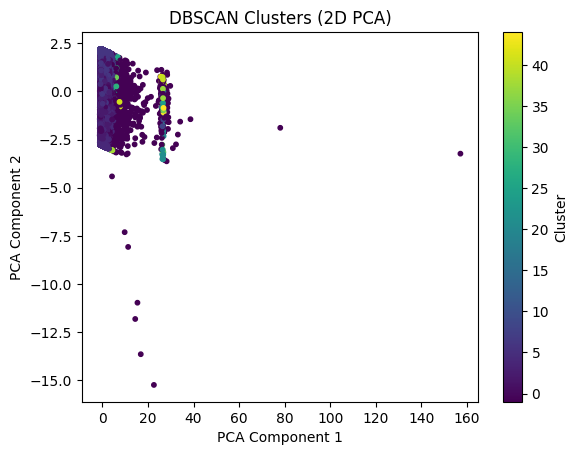

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce data to 2D using PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

# Plot clusters
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=clusters, cmap='viridis', s=10)
plt.colorbar(label='Cluster')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('DBSCAN Clusters (2D PCA)')
plt.show()

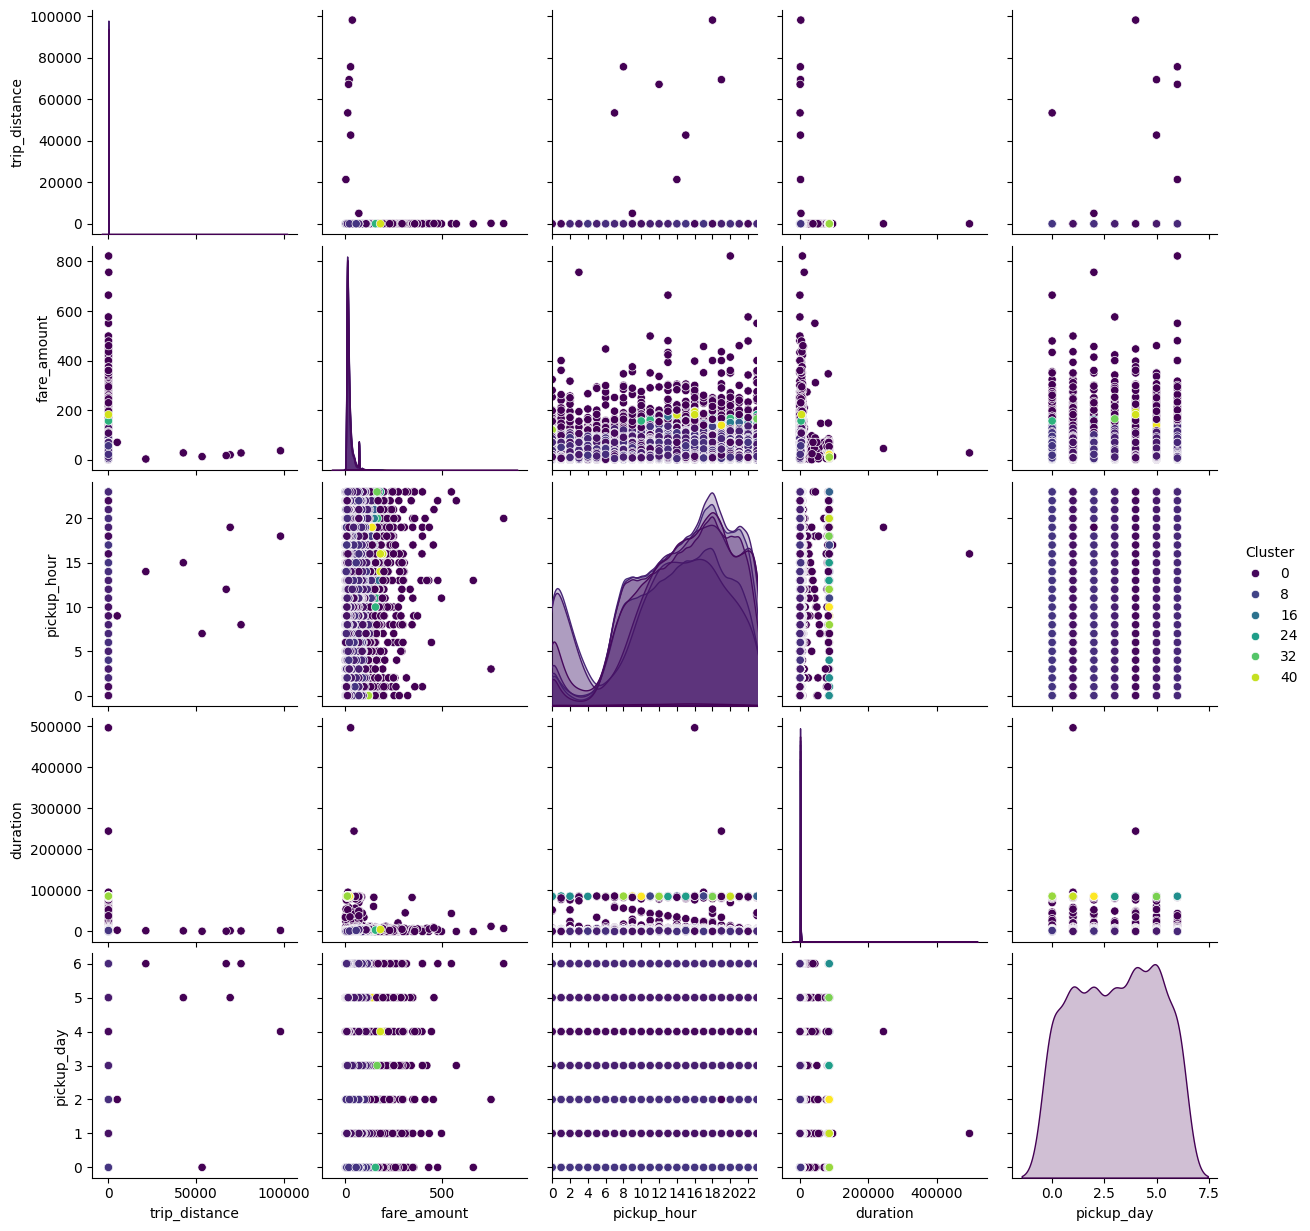

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select a few key features for visualization
features = ['trip_distance', 'fare_amount', 'pickup_hour', 'duration', 'pickup_day']

# Create the pair plot
pair_plot = sns.pairplot(data_frame, vars=features, hue='Cluster', palette='viridis')

# Adjust the x-axis limits for pickup_hour
for ax in pair_plot.axes.flatten():
    if ax.get_xlabel() == 'pickup_hour':
        ax.set_xlim(0, 23)  # Set x-axis limits to 0–23
        ax.set_xticks(range(0, 24, 2))  # Show ticks every 2 hours

plt.show()

Now we remove the outliers (filter out every value entry with cluster value -1) \
And we can also get rid of the column clusters, since we no longer have a use for it.

In [ ]:
data_frame = data_frame[data_frame['Cluster'] != -1]
data_frame = data_frame.drop(columns=['Cluster'])

distance_Q1 = data_frame['trip_distance'].quantile(0.25)
distance_Q3 = data_frame['trip_distance'].quantile(0.75)
distance_IQR = distance_Q3 - distance_Q1

distance_lower_bound = distance_Q1 - 1.5 * distance_IQR
distance_upper_bound = distance_Q3 + 1.5 * distance_IQR

distance_outliers = data_frame[(data_frame['trip_distance'] < distance_lower_bound) | (data_frame['trip_distance'] > distance_upper_bound)]
print('number of distance outliers:', len(distance_outliers))

data_frame = data_frame[(data_frame['trip_distance'] >= distance_lower_bound) & (data_frame['trip_distance'] <= distance_upper_bound)]

duration_Q1 = data_frame['duration'].quantile(0.25)
duration_Q3 = data_frame['duration'].quantile(0.75)
duration_IQR = duration_Q3 - duration_Q1

duration_lower_bound = duration_Q1 - 1.5 * duration_IQR
duration_upper_bound = duration_Q3 + 1.5 * duration_IQR

duration_outliers = data_frame[(data_frame['duration'] < duration_lower_bound) | (data_frame['duration'] > duration_upper_bound)]
print('number of duration outliers:', len(duration_outliers))

data_frame = data_frame[(data_frame['duration'] >= duration_lower_bound) & (data_frame['duration'] <= duration_upper_bound)]

number of distance outliers: 62389
number of duration outliers: 12060


Next step is to test supervised algorithms, for this we need to import the different algorithms and train them to get a model.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_log_error
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df_val = pd.read_csv("training_dataset/evaluation_dataset.csv")

features = ['trip_distance', 'fare_amount', 'pickup_hour', 'pickup_day']
target = 'duration'

X = data_frame[features]
y = data_frame[target]

X_val = data_frame[features]
y_val = data_frame[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train, y_train)

y_test_pred = knn.predict(X_test)
y_val_pred = knn.predict(X_val)

test_rmsle = root_mean_squared_log_error(y_test, y_test_pred)
print(f"Test set RMSLE: {test_rmsle:.4f}")

val_rmsle = root_mean_squared_log_error(y_val, y_val_pred)
print(f"Validation set RMSLE: {val_rmsle:.4f}")
# models = {
#     'Linear Regression': LinearRegression(),
#     'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
#     'SVR': SVR(kernel='rbf'),
#     'kNN': KNeighborsRegressor(n_neighbors=10)
# }

# results = {}

# for name, model in models.items():
#     print(f'Training {name}...')
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)

#     rmsle = root_mean_squared_log_error(y_test, y_pred)
#     results[name] = {'Mean Squared Log Error': rmsle}

# results_df = pd.DataFrame(results).T

# print(results_df)


Test set RMSLE: 0.3053
Validation set RMSLE: 0.2862
